In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

In [2]:
def ipeco_preprocessing():
    
    data = pd.read_csv('https://raw.githubusercontent.com/percepcioneseconomicas/indices/main/CEEN%20UDD%20IPECO.csv', parse_dates=True, dayfirst=True, index_col='Fecha')
    data.columns = ['ipeco', 'coyuntura', 'expectativas', 'sea', 'da', 'sef', 'df', 'iif', 'ipecotm']
    data = data.drop(['coyuntura', 'expectativas', 'ipecotm'], axis=1)

    data['ipeco'] = data['ipeco']*0.564465028
    data['sea'] = data['sea']*0.503225806
    data['da'] = data['da']*0.241887388
    data['sef'] = data['sef']*0.778145695
    data['df'] = data['df']*0.502857143
    data['iif'] = data['iif']*0.78490566

    return data

ipeco = ipeco_preprocessing()

In [3]:
imacec = pd.read_csv('https://raw.githubusercontent.com/percepcioneseconomicas/publicaciones/main/ipeco_imacec/imacec.csv', parse_dates=True, dayfirst=True, index_col='Fecha')

In [4]:
data = pd.concat([imacec, ipeco], axis=1)

In [5]:
data = data.interpolate(method='linear', limit_area='inside')
print(data.shape)
data.tail()

(256, 7)


,imacec,ipeco,sea,da,sef,df,iif
Fecha,,,,,,,
2020-12-01,-0.07,37.812376,29.559748,19.379845,51.366120,41.450777,47.305389
2021-01-01,-2.93,40.044255,28.333333,25.153374,61.111111,38.255034,47.368421
2021-02-01,-2.08,49.046441,35.714286,33.333333,68.292683,53.072626,54.819277
2021-03-01,5.77,45.474447,26.119403,32.222222,64.233577,53.048780,51.748252
2021-04-01,NaN,29.492618,17.898833,16.853933,42.412451,32.000000,38.297872


In [6]:
data = data.dropna()
data.shape

(232, 7)

Text(0, 0.5, 'IPECO')

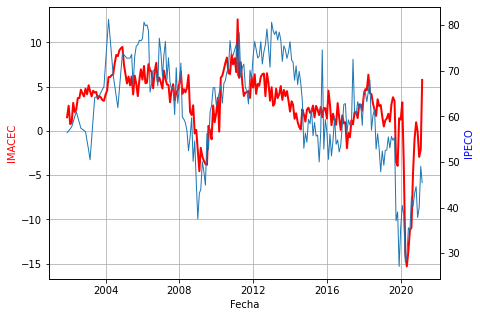

In [10]:
fig, ax1 = plt.subplots(figsize=(7,5))
ax1.plot(data['imacec'], color='red', linewidth=2)
ax1.set_xlabel('Fecha')
ax1.set_ylabel('IMACEC', color='red')
plt.grid()
ax2 = ax1.twinx()
ax2.plot(data[['ipeco']],  linewidth=1)
ax2.set_ylabel('IPECO', color='blue')

<AxesSubplot:>

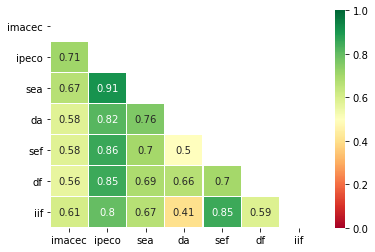

In [11]:
corr_mat = data.corr()
mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)] = True

fig, ax =plt.subplots()
sns.heatmap(corr_mat, mask=mask, annot=True, cmap='RdYlGn', linewidth=0.4, ax=ax, vmin=0, vmax=1)

In [12]:
data['presente'] = data[['sea', 'da']].mean(axis=1)
data['futuro'] = data[['sef', 'df', 'iif']].mean(axis=1)
data['personal'] = data[['sea', 'sef', 'iif']].mean(axis=1)
data['nacional'] = data[['da', 'df']].mean(axis=1)

<AxesSubplot:>

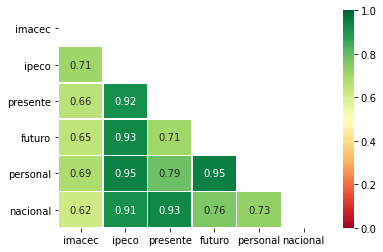

In [13]:
corr_mat = data[['imacec', 'ipeco', 'presente', 'futuro', 'personal', 'nacional']].corr()
mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)] = True

fig, ax =plt.subplots()
sns.heatmap(corr_mat, mask=mask, annot=True, cmap='RdYlGn', linewidth=0.4, ax=ax, vmin=0, vmax=1)

In [14]:
data['ipeco3'] = data['ipeco'].rolling(3).mean()
data['ipeco6'] = data['ipeco'].rolling(6).mean()
data['ipeco12'] = data['ipeco'].rolling(12).mean()

<AxesSubplot:>

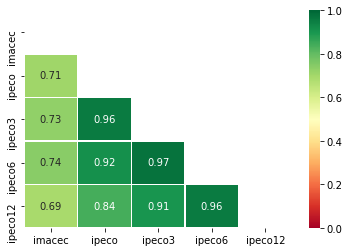

In [15]:
corr_mat = data[['imacec', 'ipeco', 'ipeco3', 'ipeco6', 'ipeco12']].corr()
mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)] = True

fig, ax =plt.subplots()
sns.heatmap(corr_mat, mask=mask, annot=True, cmap='RdYlGn', linewidth=0.4, ax=ax, vmin=0, vmax=1)

In [34]:
data['imacec-f03'] = data['imacec'].shift(-3)
data['imacec-f06'] = data['imacec'].shift(-6)
data['imacec-f12'] = data['imacec'].shift(-12)

<AxesSubplot:>

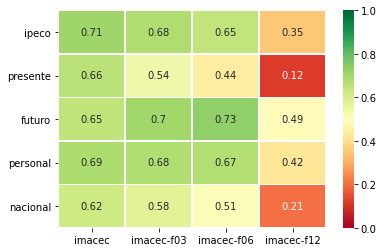

In [45]:
corr_mat = data[['imacec', 'imacec-f03', 'imacec-f06', 'imacec-f12', 'ipeco', 'presente', 'futuro', 'personal', 'nacional']].corr()
corr_mat = corr_mat[['imacec', 'imacec-f03', 'imacec-f06', 'imacec-f12']].loc[['ipeco', 'presente', 'futuro', 'personal', 'nacional']]

fig, ax = plt.subplots()
sns.heatmap(corr_mat, annot=True, cmap='RdYlGn', linewidth=0.4, ax=ax, vmin=0, vmax=1)

In [62]:
y = data['imacec']
X = data[['sea', 'da', 'sef', 'df', 'iif']]
X = (X - X.mean()) / X.std()

In [69]:
X = sm.add_constant(X, prepend=False)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

OLS Regression Results                            
Dep. Variable:                 imacec   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     49.04
Date:                Tue, 18 May 2021   Prob (F-statistic):           3.07e-34
Time:                        15:48:56   Log-Likelihood:                -547.61
No. Observations:                 232   AIC:                             1107.
Df Residuals:                     226   BIC:                             1128.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
sea            0.9214      0.335      2.750      0.006       0.261       1.582
d